## 4.1 선형회귀의 필요성

### 4.1.1 모델이 필요한 이유

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import graphviz as gr
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
style.use("ggplot")
import statsmodels.formula.api as smf
import matplotlib
from cycler import cycler

default_cycler = (cycler(color=['0.3', '0.5', '0.7', '0.5']))

color=['0.3', '0.5', '0.7', '0.9']
linestyle=['-', '--', ':', '-.']
marker=['o', 'v', 'd', 'p']

plt.rc('axes', prop_cycle=default_cycler)

gr.set_default_format("png");

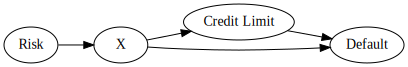

In [2]:
g_risk = gr.Digraph(graph_attr={"rankdir":"LR"})

g_risk.edge("Risk", "X")
g_risk.edge("X", "Credit Limit")
g_risk.edge("X", "Default")
g_risk.edge("Credit Limit", "Default")

g_risk

차원의 저주 문제가 발생할 수 있기에 잠재적 결과를 선형회귀 같은 방식으로 모델링할 수 있다고 가정한 후 X로 정의된 각각의 셀을 interpolate하고 extrapolate한다. 이때 선형회귀분석은 차원 축소 알고리즘으로 생각할 수 있으며 결과변수를 X로 투영한 후 투영된 값을 바탕으로 실험군과 대조운을 비교한다.

### 4.1.2 A/B 테스트와 회귀분석

새로 개발한 추천 시스템이 스트리밍 서비스의 시청 시간을 늘릴 수 있는 가를 A/B 테스트를 통해 확인

In [3]:
import pandas as pd
import numpy as np

### 고객층을 대표할 일부 고객 표본 추출 > 해당 표본에서 무작위로 1/3을 골라 새 추천 시스템 적용, 나머지는 기존 추천 시스템 적용 > 한 달 후 하루 평균 시청 시간 결과 수집
data = pd.read_csv('C:\\Users\\bumbk\\causal-inference-in-python-code\\data\\rec_ab_test.csv')
data.head()

,recommender,age,tenure,watch_time
0,challenger,15,1,2.39
1,challenger,27,1,2.32
2,benchmark,17,0,2.74
3,benchmark,34,1,1.92
4,benchmark,14,1,2.47


$$ WatchTime_i = \beta_0 + \beta_1challenger_i + e_i $$

challenger는 새로운 추천 시스템이 적용될 시 1, 그렇지 않으면 0이며 새로운 버전의 효과는 $\beta_1$의 추정값인 $\hat{\beta_1}$이 된다.

In [4]:
import statsmodels.formula.api as smf

result = smf.ols('watch_time ~ C(recommender)', data=data).fit()

result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.0491,0.058,35.367,0.000,1.935,2.163
C(recommender)[T.challenger],0.1427,0.095,1.501,0.134,-0.044,0.330


- $\beta_0$(Intercept): 이전 버전의 추천 시스템을 사용한 고객들의 예상 시청 시간(2.04 시간)
- $\hat{\beta_1}$: 매개변수 추정값(ATE 추정값)
- $\hat{\beta_0} + \hat{\beta_1}$: 새로운 버전을 이용한 고객 시청 시간의 추정값

**새로운 추천 시스템이 평균적으로 하루 시청 시간을 0.14시간 정도 늘렸다.(통계적으로 유의하진 않음)**

In [5]:
##E[Y|T] 추정
(data.groupby('recommender')['watch_time'].mean())

recommender
benchmark     2.049064
challenger    2.191750
Name: watch_time, dtype: float64

### 4.1.3 회귀분석을 통한 보정

In [6]:
risk_data = pd.read_csv('C:\\Users\\bumbk\\causal-inference-in-python-code\\data\\risk_data.csv')
risk_data.head()

,wage,educ,exper,married,credit_score1,credit_score2,credit_limit,default
0,950.0,11,16,1,500.0,518.0,3200.0,0
1,780.0,11,7,1,414.0,429.0,1700.0,0
2,1230.0,14,9,1,586.0,571.0,4200.0,0
3,1040.0,15,8,1,379.0,411.0,1500.0,0
4,1000.0,16,1,1,379.0,518.0,1800.0,0


$$ ATE = \frac{\partial}{\partial t} E[y\,|\,t] $$

ATE를 여러 처치 수준 간 차이로 표현하는 대신 기대 결과의 처치에 대한 도함수(derivative)로 표현

처치가 한 단위 증가할 때 결과가 얼마나 변할지에 대한 기댓값(위 사례에서는 신용 한도가 1달러 증가했을 때 채무불이행률이 얼마나 변할지에 대한 기댓값을 나타냄)

$$ Default = \beta_0 + \beta_1 line_i + e_i $$

위 모델을 통해 추정량을 추정할 수 있으며 추정된 $ \hat{\beta_1} $은 신용 한도가 1달러 증가할 때 채무불이행률이 얼마나 변할지에 대한 기댓값

이때 신용 한도가 무작위로 배저오디었다면 이 매개변수를 인과적으로 해석할 수 있으나 은행은 위험이 적은 고객에게 더 높은 한도를 주는 경향이 있기에 그럴 순 없음

In [7]:
model = smf.ols('default ~ credit_limit', data=risk_data).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2192,0.004,59.715,0.000,0.212,0.226
credit_limit,-2.402e-05,1.16e-06,-20.689,0.000,-2.63e-05,-2.17e-05


Text(0.5, 1.0, 'Default Rate by Credit Limit')

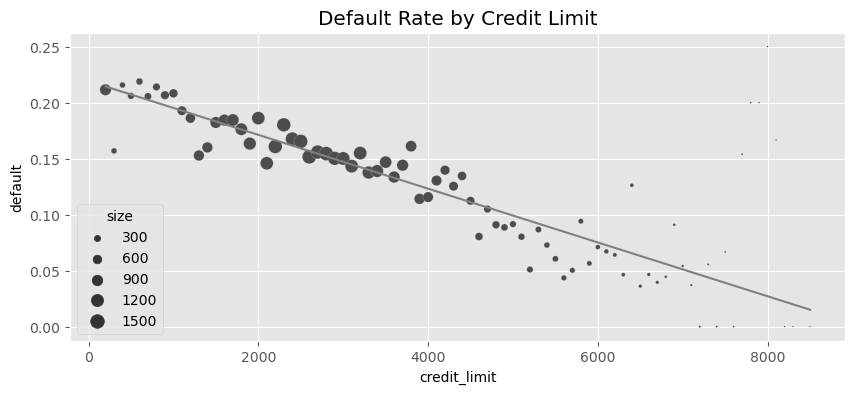

In [8]:
plt_df = (risk_data
          .assign(size=1)
          .groupby("credit_limit")
          .agg({"default": "mean", "size":sum})
          .reset_index()
          .assign(prediction = lambda d: model.predict(d)))

plt.figure(figsize=(10,4))

sns.scatterplot(data=plt_df,
                x="credit_limit",
                y="default",
                size="size",
                sizes=(1,100))

plt.plot(plt_df["credit_limit"], plt_df["prediction"], color="C1")
plt.title("Default Rate by Credit Limit")

여기서 발생한 편향을 보정하기 위해서는 이론적으로 모든 교란 요인에 따라 아래와 같은 절차를 따라야 함.

1. 데이터를 나눈다.
2. 나눈 각 그룹 내에서 채무불이행률을 신용 한도에 회귀한다.
3. 기울기 매개변수 추출을 통해 결과의 평균을 구한다.

In [9]:
risk_data.groupby(['credit_score1','credit_score2']).size().head()

credit_score1  credit_score2
34.0           339.0            1
               500.0            1
52.0           518.0            1
69.0           214.0            1
               357.0            1
dtype: int64

그러나 위 절차를 따르기에는 차원의 저주로 인해 적절한 수의 교란 요인(두 가지 신용점수)을 고려했을 때조차 위처럼 표본이 하나뿐인 셀이 존재함.

해당 표본으로는 회귀할 수 없으며 많은 셀이 비어 있음.

$$ Default_i = \beta_0 + \beta_1 line_i + \theta X_i + e_i $$

회귀분석을 통해 교란 요인을 직접 보정하는 대신 OLS로 추정할 모델에 단순히 교란 요인을 추가함으로써 이 상황을 해결할 수 있음

- X: 교란 요인의 벡터
- $\theta$: 해당 교란 요인과 관련된 매개변수의 벡터($\beta_1$과 똑같이 작동, 편향되지 않은 $\beta_1$의 추정값을 얻는 데 도움이 되고 이 매개변수의 인과관계 해석에는 크게 신경쓰지 않아도 됨, **장애모수(Nuisance Parameter)** 라고 부름)

위 예제에서는 신용점수와 임금을 교란 요인으로 모델에 추가할 수 있으며 아래와 같은 모델을 만들 수 있음

$$ Default_1 = \beta_0 + \beta_1 line_i + \theta_1 wage_i + \theta_2 creditScore1_i + \theta_3 creditScore2_i + e_i $$

위 수식은 $E[y|t, X]$에 대한 것이고 원하는 모델은 $\frac{\partial}{\partial t} E[y | t,X]$이므로 위 수식을 처치인 신용 한도에 대해 미분한다면 결과는 $\beta_!$이 나옴

$\beta_1$의 경우 신용 한도에 대한 채무불이행률 기댓값의 편도함수로 볼 수 있으며 다시 말해 모델의 다른 보든 변수가 고정된 상태에서 신용 한도를 조금 늘렸을 때 채무불이행률이 얼마나 변할지에 대한 기댓값임

이를 통해 회귀분석이 교란 요인을 어떻게 보정하는지 알 수 있으며 처치와 결과 사이의 관계를 추정하는 동안 교란 요인을 고정한다는 것을 확인할 수 있음

이를 확인하기 위해 이전 모델을 추정하면 되며 몇가지 교란 요인을 추가하면 신용한도와 채무불이행률 사이의 관계가 양수로 바뀌게 됨

In [10]:
formula = 'default ~ credit_limit + wage + credit_score1 + credit_score2'
model = smf.ols(formula, data=risk_data).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4037,0.009,46.939,0.000,0.387,0.421
credit_limit,3.063e-06,1.54e-06,1.987,0.047,4.16e-08,6.08e-06
wage,-8.822e-05,6.07e-06,-14.541,0.000,-0.000,-7.63e-05
credit_score1,-4.175e-05,1.83e-05,-2.278,0.023,-7.77e-05,-5.82e-06
credit_score2,-0.0003,1.52e-05,-20.055,0.000,-0.000,-0.000


신용 한도를 늘릴수록 채무불이행률이 증가함을 알 수 있으며 교란 요인을 통제함으로써 보다 직관적인 해석으로 바뀌게 됐으믕ㄹ 확인할 수 있음

***신용 한도의 단위는 1,000이고 채무불이행 여부는 0또는 1이므로 신용 한도가 1달러 증가할 때 채무불이행률이 증가하는 정도는 매우 작으므로 계수는 문제 없음***

## 4.2 회귀분석 이론


$$ \beta^* = argminE[(Y_i - X^\prime_i\beta)^2] $$

- $\beta^*$: 매개변수 벡터

선형회귀분석의 경우 MSE(Mean Squared error)를 최소화하는 매개변수를 찾으며 이를 미분하고 그 결과를 0으로 두면 아래와 같이 선형 해가 나오게 됨

$$ \beta^* = E[X^\prime X]^{-1} E[X^\prime Y] $$

표본을 통해 아래와 같이 회귀계수를 추정할 수 있음

$$ \hat{\beta} = (X^\prime X)^{-1} X^\prime Y $$

In [11]:
### OLS의 대수적 해를 사용해 앞 모데의 매개변수를 추정

X_cols = ['credit_limit', 'wage', 'credit_score1', 'credit_score2']
X = risk_data[X_cols].assign(intercep=1)
y = risk_data['default']

def regress(y, X):
    return np.linalg.inv(X.T.dot(X)).dot(X.T.dot(y))

beta = regress(y, X)
beta

array([ 3.06252773e-06, -8.82159125e-05, -4.17472814e-05, -3.03928359e-04,
        4.03661277e-01])

앞서 statsmodels의 ols함수를 사용해 모델을 추정할 때 얻은 값과 동일

### 4.2.1 단순선형회귀

단일 설명변수 T를 사용할 때 관련된 매개변수는 아래와 같으며 단순선형회귀분석을 통해 이 효과를 추정할 수 있음

$$ \hat{\tau} = \frac{Cov(Y_i,T_i)}{Var(T_i)} = \frac{E[(T_i-\bar{T})(Y_i - \bar{Y})]}{E[(T_i - \bar{T})^2]} $$

$T$가 무작위로 배정된 경우 $\beta_1$은 ATE임

### 4.2.2 다중선형회귀

설명변수가 2개 이상일 때는 단순선형회귀분석을 확장하고 결국에는 관심 있는 부분인 $T$와 관련된 매개변수 $\tau$를 추정하는 것

$$ y_i = \beta_0 + \tau T_i + \beta_1 X_{1i} + \cdots + \beta_k X_ki + u_i $$

$\tau$는 아래 공식으로 추정할 수 있음
$$ \hat{\tau} = \frac{Cov(Y_i,\tilde{T_i})}{Var(\tilde{T_i})} $$

이때 $\tilde{T_i}$는 $T_i$를 모든 공변량 $X_{1i} + \cdots + X_{ki}$에 대해 회귀한 잔차(residual)임
인과추론 관점에서 볼 때 $\tau$는 다른 모든 변수를 활용해 $T$를 예측한 후 얻은 T의 이변량(bivariate) 계수

직관적으로 볼 때 다른 변수를 사용하여 $T$를 예측할 수 있다면 $T$는 무작위가 아니지만 모든 교란 요인 $X$를 통제하면 $T$를 무작위처럼 보이게 할 수 있음
이를 위해서는 선형회귀분석을 통해 교란 요인에서 $T$를 예측한 후 $T$에서 해당 회귀에 대한 잔차인 $\tilde T$를 빼주면 됨

## 4.3 프리슈-워-로벨 정리와 직교화

- 가장 먼저 사용할 수 있는 편향 제거(debiasing) 기법
- 비실험 데이터를 처치가 무작위 배정된 것처럼 보이게 함

FWL 정리에 따르면 다중선형회귀분석은 한 번에 추정하거나 세 단계로 나누어 추정할 수 있음
아래와 같이 채무불이행률 default를 credit_limit, wage, credit_score1, credit_score2에 대해 회귀 가능

In [12]:
formula = 'default ~ credit_limit + wage + credit_score1 + credit_score2'
model = smf.ols(formula, data=risk_data).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4037,0.009,46.939,0.000,0.387,0.421
credit_limit,3.063e-06,1.54e-06,1.987,0.047,4.16e-08,6.08e-06
wage,-8.822e-05,6.07e-06,-14.541,0.000,-0.000,-7.63e-05
credit_score1,-4.175e-05,1.83e-05,-2.278,0.023,-7.77e-05,-5.82e-06
credit_score2,-0.0003,1.52e-05,-20.055,0.000,-0.000,-0.000


그러나 FWL 정리에 따르면 추정 과정을 다음과 같이 세 단계로 나눌 수 있음

1. 편향 제거 단계: 처치 $T$를 교란 요인 $X$에 회귀하여 처치 잔차 $\tilde T = T - \hat T$를 구한다.
2. 잡음 제거 단계: 결과 $Y$를 교란 요인 X에 대해 회귀하여 결과 잔차 $\tilde Y = Y - \hat Y$를 구한다.
3. 결과 모델 단계: 결과 잔차 $\tilde Y$를 처치 잔차 $\tilde T$에 대해 회귀하여 T가 Y에 미치는 인과효과 추정값을 구한다.

이는 그거 앞서 살펴 본 다중선형회귀분석을 다시 설명한 것이며 FWL 정리는 이 추정 단계와 회귀 모델이 본질적으로 같음을 보여줌
또한 첫 번째 단계와 같이 선형회귀의 편향 제거 구성 요소를 분리할 수 있음을 보여줌

### 4.3.1 편향 제거 단계

Text(0.5, 1.0, 'Default Rate by Credit Limit')

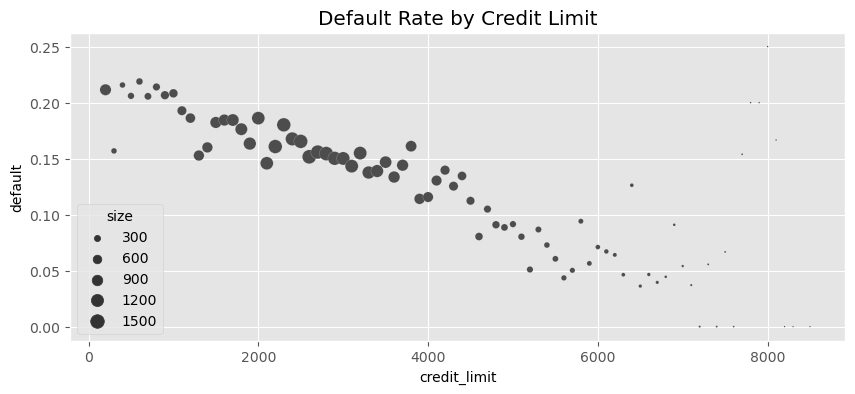

In [13]:
plt_df = (risk_data
          .assign(size=1)
          .groupby("credit_limit")
          .agg({"default": "mean", "size":sum})
          .reset_index())

plt.figure(figsize=(10,4))
sns.scatterplot(data=plt_df,
                x="credit_limit",
                y="default",
                size="size",
                sizes=(1,100))


plt.title("Default Rate by Credit Limit")

처음에는 교란편향의 영향으로 신용 한도에 따라 채무불이행률이 감소하는 추세를 보임

FWL 정리에 따르면 교란 요인으로부터 처치인 신용 한도를 예측하는 회귀 모델을 적합시켜 데이터의 편향을 제거할 수 있음
이후 이 모델로부터 신용 한도에 대한 잔차 $(\widetilde{line} = line_i - \widehat{line_i})$를 구함(해당 잔차는 편향 제거 모델에 사용된 변수와는 상관관계가 없는 버전의 처치로 볼 수 있음)
이는 예측 값을 생선한 변수와 직교하기 때문임
이 단계를 수행하면 0을 중심으로 한 $\widetilde{line}$이 만들어지며 필요에 따라 평균 처치인 $\overline{line}$을 다시 추가할 수 있음

$$ \widetilde{line_i} = line_i - \widehat{line_i} + \overline{line} $$

편향 제거에 필요하지는 않으나 시각화 목적으로 $\widetilde{line}$을 원래의 $line$과 같은 범위에 두는 것이 좋음

In [14]:
debiasing_model = smf.ols(
    'credit_limit ~ wage + credit_score1 + credit_score2',
    data=risk_data
).fit()

risk_data_deb = risk_data.assign(
    #시각화를 위해 avg(T)를 잔차에 추가
    credit_limit_res=(debiasing_model.resid
                    +risk_data['credit_limit'].mean())
)

$default$를 편향 제거된(잔차화된) 처치인 $\widetilde{line}$에 회귀하면 편향 제거 모델에 사용된 교란 요인들을 통제하며 신용 한도가 채무불이행률에 미치는 영향을 파악할 수 있음

여기서 $\beta_1$에 대한 매개변수 추정값은 아서 처치와 교란 요인을 모두 포함한 완전 모델(full model)을 실행하여 얻은 값과 정확히 일치함

In [15]:
model_w_deb_data = smf.ols('default ~ credit_limit_res',
                          data=risk_data_deb).fit()

model_w_deb_data.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1421,0.005,30.001,0.000,0.133,0.151
credit_limit_res,3.063e-06,1.56e-06,1.957,0.050,-4.29e-09,6.13e-06


다만 위에서 나온 p 값이 이전보다 높은 것을 확인할 수 있는데 이는 분산 감소를 담당하는 잡음 제거(denoising) 단계를 거치지 않았기 때문임
그러나 편향 제거 단계만 적용해도 모든 ㄱ란 요인이 편향 제거 모델에 포함된다면 신용 한도가 채무불이행률(채무불이행 위험)에 미치는 인과적 영향에 대해 편햐오디지 않은 추정값(unbiased estimate)를 얻을 수 있음

이를 시각화해보면 아래와 같으며 편향되었을 때와 달리 두 변수 사이의 관계가 하향선을 그리지 않고 보다 평행하게 바뀜을 알 수 있음

Text(0.5, 1.0, 'Default Rate by Debiased Credit Limit')

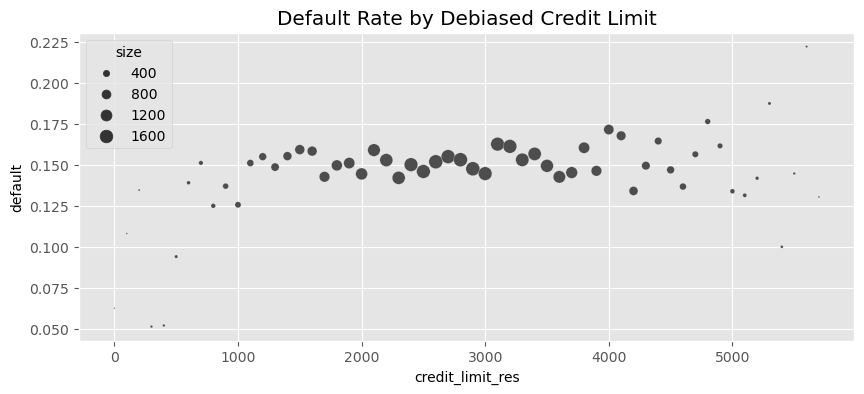

In [16]:
plt_df = (risk_data_deb
          .assign(size=1)
          .assign(credit_limit_res = lambda d: d["credit_limit_res"].round(-2))
          .groupby("credit_limit_res")
          .agg({"default": "mean", "size":sum})
          .query("size>30")
          .reset_index())

plt.figure(figsize=(10,4))
sns.scatterplot(data=plt_df,
                x="credit_limit_res",
                y="default",
                size="size",
                sizes=(1,100))

plt.title("Default Rate by Debiased Credit Limit")

### 4.3.2 잡음 제거 단계

잡음 제거의 경우 처치효과의 추정값을 바꾸진 못하지만 분산을 줄일 수 있으며 이 단계에서는 결과를 처치가 아닌 공변랴엥 대해 회귀함
이후 $\widetilde{default_i} = default_i - \widehat{default_i}$에 대한 잔차를 얻음

시각화 목적으로 잡음이 제거된 채무불이행률 변수에 평균 채무불이행률을 더할 수 있음

$$ \widetilde{default_i} = default_i - \widehat{default_i} + \overline{default} $$

In [17]:
denoising_model = smf.ols(
    'default ~ wage + credit_score1 + credit_score2',
    data=risk_data_deb
).fit()

risk_data_denoise = risk_data_deb.assign(
    default_res=denoising_model.resid + risk_data_deb['default'].mean()
)

### 4.3.3 회귀 추정량의 표준오차

추정한 회귀계쑤의 표준오차 공식은 아래와 같음
$$ SE(\hat{\beta}) = \frac{\sigma(\hat{\epsilon})}{\sigma(\tilde{T}\sqrt{n-DF})} $$

여기서 $\hat{\epsilon}$는 회귀 모델의 잔차이고 $DF$는 모델의 자유도(모델이 추정하는 매개변수의 수)임

In [18]:
model_se = smf.ols(
    'default ~ wage + credit_score1 + credit_score2',
    data=risk_data
).fit()

print('SE regression:', model_se.bse['wage'])


model_wage_aux = smf.ols(
    'wage ~ credit_score1 + credit_score2',
    data=risk_data
).fit()

#모델의 자유도: N-4
se_formula = (np.std(model_se.resid)
             /(np.std(model_wage_aux.resid) * np.sqrt(len(risk_data)-1)))

print('SE formula:   ', se_formula)

SE regression: 5.364242347548206e-06
SE formula:    5.364081414645078e-06



결과를 잘 예측할수록 잔차가 작아지므로 추정값의 분산이 낮아지며 처치가 결과를 많이 설명하면 매개변수 추정값의 표준오차도 작아짐을 알 수 있음

오차는 잔차화된 처치의 분산에 반비례하며 처치가 많이 바뀔수록 그 영향을 측정하기 더 쉬워짐

### 4.3.4 최종 결과 모델

FWL 정리의 마지막 단계인 결과 모델에서는 두 잔차 $\tilde Y$와 $\tilde T$를 이용해 단순히 $\tilde Y$를 $\tilde T$에 대해 회귀하면 됨

In [19]:
model_w_orthogonal = smf.ols('default_res ~ credit_limit_res',
                            data=risk_data_denoise).fit()

model_w_orthogonal.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1421,0.005,30.458,0.000,0.133,0.151
credit_limit_res,3.063e-06,1.54e-06,1.987,0.047,4.17e-08,6.08e-06


결과를 확인했을 때 편향 제거 단계에서 얻은 매개변수 추정값은 신용 한도와 다른 모든 공변량을 사용하여 회귀했을 때와 완전히 동일함을 알 수 있음

또한 표준오차와 p 값도 모든 변수를 포함하여 처음 모델을 실행했을 때와 같으며 이것이 잡음 제거 단계의 효과

Text(0.5, 1.0, 'Denoised Default Rate by Debiased Credit Limit')

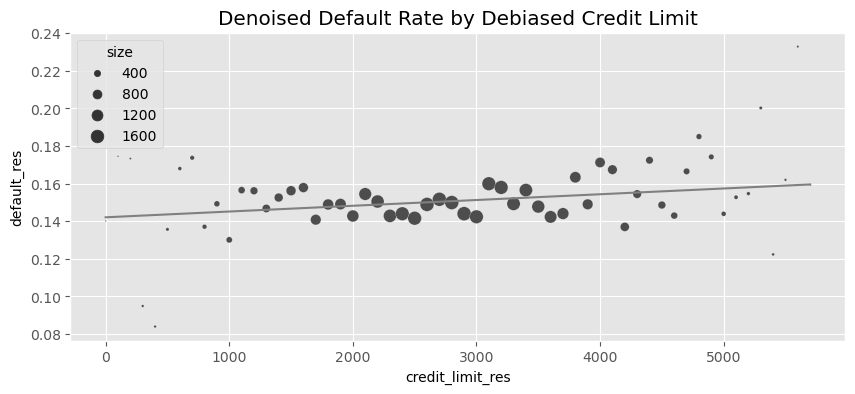

In [20]:
plt_df = (risk_data_denoise
          .assign(size=1)
          .assign(credit_limit_res = lambda d: d["credit_limit_res"].round(-2))
          .groupby("credit_limit_res")
          .agg({"default_res": "mean", "size":sum})
          .query("size>30")
          .reset_index()
          .assign(prediction = lambda d: model_w_orthogonal.predict(d)))

plt.figure(figsize=(10,4))
sns.scatterplot(data=plt_df,
                x="credit_limit_res",
                y="default_res",
                size="size",
                sizes=(1,100))

plt.plot(plt_df["credit_limit_res"], plt_df["prediction"], c="C1")

plt.title("Denoised Default Rate by Debiased Credit Limit")

위와 같이 편향 제거된 처치와 잡음 제거된 결과 간의 관계를 최종 모델의 예측값과 함께 그래프로 나타낼 수 있음

### 4.3.5 FWL 정리 요약

처치 $T$와 결과 $Y$ 사이의 관계를 추정하고 싶으나 교란 요인 $X$가 있다고 가정했을 때  
처음 처치와 결과는 음의 기울기였으나 도메인 지식으로 볼 때 이 관계는 본래 양의 관계여야 한다고 확신할 수 있음  
따라서 데이터의 편향을 제거하기로 함  


이를 위해서는 먼저 선형회귀분석을 통해 $E[T|X]$를 추정한 후 편향이 제거된 버전의 처치인 $T-E[T|X]$를 구함  
이 과정을 통해 찾고자 하는 양의 관계를 확인할 수 있음


그러나 여전히 잡음이 많음을 확인할 수 있고 이를 처리하기 위해 회귀 모델을 사용하여 $E[Y|X]$를 추정하고 잡음 제거된 결과 $Y-E[Y|X]$를 만듦  
이 잡음 제거된 결과를 $X$에 의해 설명된 모든 분산을 고려한 후의 결과로 볼 수 있음  
$X$가 $Y$의 분산을 많이 설명할수록 잡음 제거된 결과에는 잡음이 적어지므로 실제로 관심 있는 $T$와 $Y$ 사이의 관계를 더 쉽게 파악할 수 있음

## 4.4 결과 모델로서의 회귀분석

회귀분석은 처치를 직교화하는 방식이기도 하지만 잠재적 결과를 대체(imputation)하는 방법으로도 볼 수 있음
처치가 0 또는 1의 이진값으로 주어진다고 가정했을 때, 대조군$(T=0)$에서 $X$에 대한 $Y$의 회귀분석이 $E[Y_0|X]$를 잘 근사한다면 해당 모델을 이용해 $Y_0$를 대체하고 ATT를 추정할 수 있음

$$ ATT = \frac{1}{N_1} \sum\mathbf{1}(T_i=1)(Y_i - \hat{\mu_0}(X_i)) $$

이때 N_1은 실험군 대상자의 수 이고 $\mathbf{1}$은 지시 함수(indicator function)를 뜻함(안에 있는 인수가 참이면 1을 반환하고 그렇지 않으면 0을 반환)

마찬가지로 실험군$(T=1)$에서 $X$에 대한 $Y$의 회귀분석이 $E[Y_1|X]$를 잘 모델링할 수 있다면 이를 이용하여 대조군에서의 평균 효과를 추정할 수도 있음
두 접근법을 병행하여 다음과 같이 ATE를 추정할 수 있음

$$ ATE = \frac{1}{N}\sum(\hat{\mu_1}(X_i) - \hat{\mu_0}(X_i)) $$

이 추정량은 모든 실험 대상의 두 가지 잠재적 결과 모두를 대체하며 $Y$를 $X$와 $T$ 모두에 회귀하고 $T$에 대한 매개변수 추정값을 얻는 것과 동일함  
아래와 같이 누락된 잠재적 결과를 대체할 수도 있음

$$ ATE = \frac{1}{N}\sum(\mathbf{1}(T_I=1)[Y_i - \hat{\mu_0}(X_i)] + \mathbf{1}(T_i=0)[\hat{\mu_1}(X_i) - Y_i]) $$

$T$가 연속형일 경우 개념화하기 더 어려우나 회귀분석은 전체 처치 반응 함수를 대체하는 것으로 이해할 수 있으며 여기에는 잠재적 결과 $Y(t)$를 선처럼 대체하는 것이 포함됨

$E[T|X]$를 정확하게 추정하여 직교화할 수 있거나 잠재적 결과 $E[Y_t|X]$를 정확하게 추정할 수 있다는 사실은 회귀분석이 doubly robust하다는 특성을 나타냄

* 처치 반응 함수는 연속형 처치의 다양한 수준에 대한 결과의 기댓값을 나타냄으로써 처치 수준의 변화가 결과에 어떤 영향을 미치는지 설명한다. 회귀분석을 통해 이 함수를 추정하고 처치의 변화가 결과에 미치는 효과를 분석할 수 있음

## 4.5 양수성과 외삽

회귀분석은 잠재적 결과를 모수적(parametric)으로 모델링하므로 데이터의 처치 범위 이외에 대해서도 외삽을 할 수 있음  
그러나 외삽의 합리성 여부에 따라 좋을 수도 있고 안 좋을 수도 있음

중첩(overlap)이 적은 데이터셋에서 처치효과를 추정해야 한다고 가정하고 이를 데이터셋 1이라 칭함  
데이터셋 1에서 공변량 $x$의 값이 클 때는 대조군이 존재하지 않고 작을 때는 실험군이 없음
이 데이터에 회귀분석을 활용하여 처치효과를 추정하면 첫 번째 그래프의 선과 같이 $Y_0$와 $Y_1$을 추정함

Text(0.5, 1.0, 'Dataset 2')

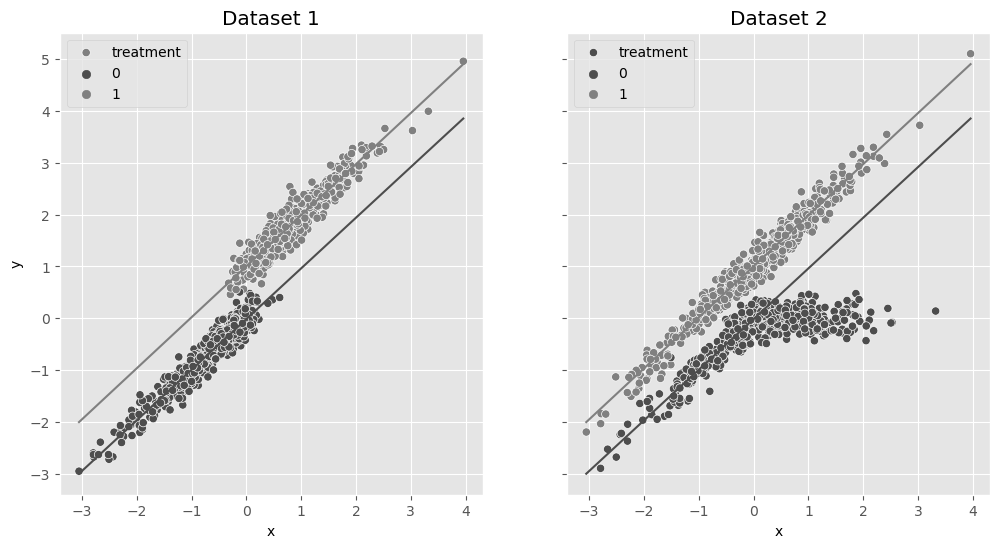

In [21]:
np.random.seed(1)

n = 1000
x = np.random.normal(0, 1, n)
t = np.random.normal(x, 0.2, n) > 0

y0 = x 
y1 = 1 + x

y = np.random.normal((1-t)*y0 + t*y1, 0.2)

df_no_pos = pd.DataFrame(dict(x=x,t=t.astype(int),y=y))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

sns.scatterplot(data=df_no_pos, x="x", y="y", hue="t", ax=ax1, label="treatment")

m0 = smf.ols("y~x", data=df_no_pos.query(f"t==0")).fit()
m1 = smf.ols("y~x", data=df_no_pos.query(f"t==1")).fit()

sns.lineplot(data=df_no_pos.assign(pred=m0.predict(df_no_pos)), x="x", y="pred", color=f"C0", ax=ax1)
sns.lineplot(data=df_no_pos.assign(pred=m1.predict(df_no_pos)), x="x", y="pred", color=f"C1", ax=ax1);
ax1.set_title("Dataset 1")

np.random.seed(1)

n = 1000
x = np.random.normal(0, 1, n)
t = np.random.binomial(1, 0.5, size=n)

y0 = x * (x<0) + (x>0)*0
y1 = 1 + x

y = np.random.normal((1-t)*y0 + t*y1, 0.2)

df_pos = pd.DataFrame(dict(x=x,t=t.astype(int),y=y))

sns.scatterplot(data=df_pos, x="x", hue="t", y="y", ax=ax2, label="treatment")

sns.lineplot(data=df_no_pos.assign(pred=m0.predict(df_pos)), x="x", y="pred", color=f"C0", ax=ax2)
sns.lineplot(data=df_no_pos.assign(pred=m1.predict(df_pos)), x="x", y="pred", color=f"C1", ax=ax2)
ax2.set_title("Dataset 2")

$x$가 작을 때 대조군에 적합시킨 $Y_0$과 $x$ 간의 관계가 $x$가 클 때도 유효하고 실험군에 적합시킨 $Y_1$이 $x$가 작ㅇ르 때도 잘 외삽할 수 있다면 문제가 없음  
즉, 공변량 공간 전반에 중첩이 있는 결과 추세선이 비슷하면 약간의 외삽은 문제가 되지 않음

그러나 지나친 외삽은 위험할 수 있음. 데이터셋 1에서 효과를 추정했지만 더 많은 데이터를 수집하여 처치를 무작위로 배정하게 됐다고 가정했을 때, 새로운 데이터인 데이터셋 2에서는 $x$가 양수일 때 효과가 점점 커지는 것을 확인할 수 있음

따라서 이전에 적합시킨 모델을 데이터셋 2에 대해 평가하면 처치의 실제 처치효과보다 과소평가했음을 알 수 있음

이는 양수성 가정이 충족되지 않는 영역으로 특정 처치를 전혀 받지 않을 확률이 있는 범위에서의 처치효과는 정확히 알 수 없음을 보여줌  
이러한 범위에 대한 외삽을 신뢰할 수도 있지만 이에 따른 위험을 감수해야 하는 것임

결국 양수성 가정이 충족되지 않을 경우 회귀분석은 외삽을 통해 해당 가정이 충족되지 않는 영역을 대체하게 됨

## 4.6 선형회귀에서의 비선형성

지금까지는 처치 반응 곡선이 꽤 선형적으로 보였으나 실제로는 선형적이지 않는 상황을 마주할 가능성이 높음

In [22]:
spend_data = pd.read_csv('C:\\Users\\bumbk\\causal-inference-in-python-code\\data\\spend_data.csv')
spend_data.head()

,wage,educ,exper,married,credit_score1,credit_score2,credit_limit,spend
0,950.0,11,16,1,500.0,518.0,3200.0,3848
1,780.0,11,7,1,414.0,429.0,1700.0,3144
2,1230.0,14,9,1,586.0,571.0,4200.0,4486
3,1040.0,15,8,1,379.0,411.0,1500.0,3327
4,1000.0,16,1,1,379.0,518.0,1800.0,3508


상황을 간소화하여 유일한 교란 요인은 임금이라고 가정했을 때 인과 그래프는 아래와 같음(은행에서 신용 한도를 결정할 때 유일하게 임금 정보만을 사용한다는 뜻)

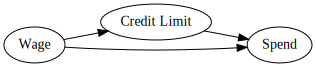

In [23]:
g_risk = gr.Digraph(graph_attr={"rankdir":"LR"})

g_risk.edge("Wage", "Credit Limit")
g_risk.edge("Wage", "Spend")
g_risk.edge("Credit Limit", "Spend")

g_risk

이 상황에서 신용 한도가 소비에 미치는 영향을 파악하려면 임금을 통제해야 함  
효과 추정에 직교화를 사용하고 싶다면 신용 한도를 임금에 회귀하고 그 잔차를 구해 신용 한도의 편향을 제거해야 함

그러나 이때 여러 임금 수준에서 신용 한도별 소비 그래프를 그려보면 두 변수 사이의 관계는 선형적이지 않음을 확인할 수 있음

<Axes: xlabel='credit_limit', ylabel='spend'>

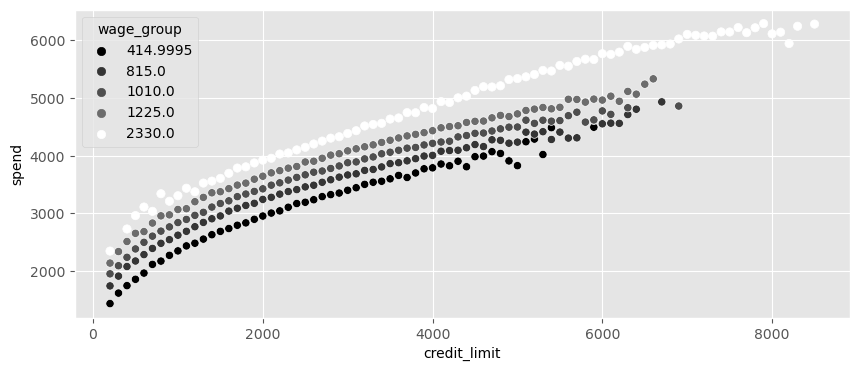

In [24]:
plt_df = (spend_data
          .assign(wage_group = lambda d: pd.IntervalIndex(pd.qcut(d["wage"], 5)).mid)
          .groupby(["wage_group", "credit_limit"])
          [["spend"]]
          .mean()
          .reset_index())

plt.figure(figsize=(10,4))
sns.scatterplot(data=plt_df, 
                x="credit_limit",
                y="spend",
                hue="wage_group",
                palette="gray")

오히려 처치 반응 곡선에서는 오목한 부분인 오목성(concavity)가 있으며 이는 신용 한도가 높을수록 곡선의 기울기가 낮아짐을 뜻함

기울기와 인과효과는 밀접한 관련이 있으므로 인과 추론 관점에서 신용 한도가 증가함에 따라 한도가 소비에 미치는 효과는 감소한다고 볼 수 있음

이는 곧 한도를 2,000에서 3,000으로 늘렸을 때보다 1,000에서 2,000으로 늘렸을 때 소비가 더 많이 증가함을 의미함

### 4.6.1 처치 선형화

이 문제를 해결하기 위해서는 먼저 처치를 결과와 선형 관계로 변환해야 함  
예를 들어 관계가 오목하므로 신용 한도에 오목 함수를 적용해 볼 수 있음. 로그 함수, 제곱근 함수 또는 신용 한도를 분수의 거듭제곱으로 취하는 함수라면 어떤 것이든 좋은 후보가 될 수 있음

아래는 제곱근을 사용한 그래프임


<Axes: xlabel='credit_limit_sqrt', ylabel='spend'>

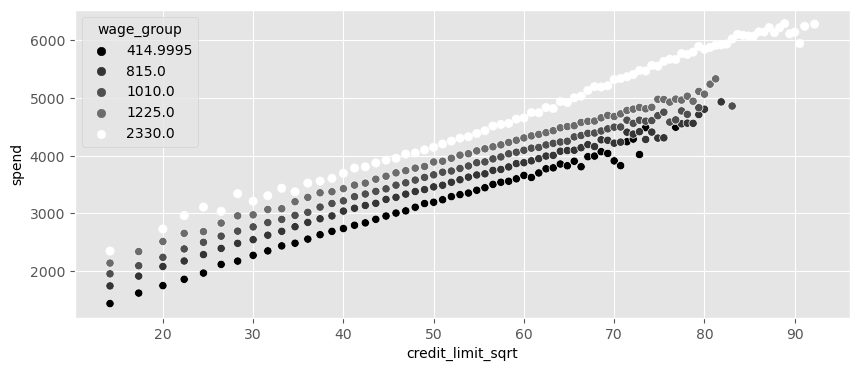

In [25]:
plt_df = (spend_data
          # apply the sqrt function to the treatment
          .assign(credit_limit_sqrt = np.sqrt(spend_data["credit_limit"]))
          # create 5 wage binds for better vizualization
          .assign(wage_group = pd.IntervalIndex(pd.qcut(spend_data["wage"], 5)).mid)
          .groupby(["wage_group", "credit_limit_sqrt"])
          [["spend"]]
          .mean()
          .reset_index())

plt.figure(figsize=(10,4))
sns.scatterplot(data=plt_df, 
                x="credit_limit_sqrt",
                y="spend",
                palette="gray",
                hue="wage_group")

이전 그래프보다 나아진 것을 확인할 수 있으며 신용 한도의 제곱근은 소비와 선형 관계가 있는 것으로 볼 수 있음(약간의 곡선이 남아 있는 것으로 보이나 괜찮은 것으로 판단)

이 과정에서 다양한 함수를 시도해보고 어떤 함수가 처치를 가장 잘 선형화하는지 직접 확인해야 함  
만족스러운 함수를 찾았다면 해당 함수를 적용한 선형회귀모델을 실행할 수 있으며 본 예시에서는 아래와 같은 모델을 추정하게 됨

$$ spend_i = \beta_0 + \beta_1 \sqrt{line_i} + e_i $$

찾고 싶은 인과 매개변수는 $\beta_1$이며 해당 모델은 statsmodels에 numpy 제곱근 함수를 사용해 추정할 수 있음

In [26]:
model_spend = smf.ols(
    'spend ~ np.sqrt(credit_limit)', data=spend_data
).fit()

model_spend.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,493.0044,6.501,75.832,0.000,480.262,505.747
np.sqrt(credit_limit),63.2525,0.122,519.268,0.000,63.014,63.491


그러나 아직 임금이 신용 한도와 소비 사이에서 교란 요인으로 작용하여 있기에 이전 모델의 예측값과 원본 데이터를 그래프에 나타내보면 기울기가 상향 편향되어 있음을 알 수 있음

이는 임금이 높아지면 소비와 신용한도 모두 증가하기 때문

<Axes: xlabel='credit_limit', ylabel='spend'>

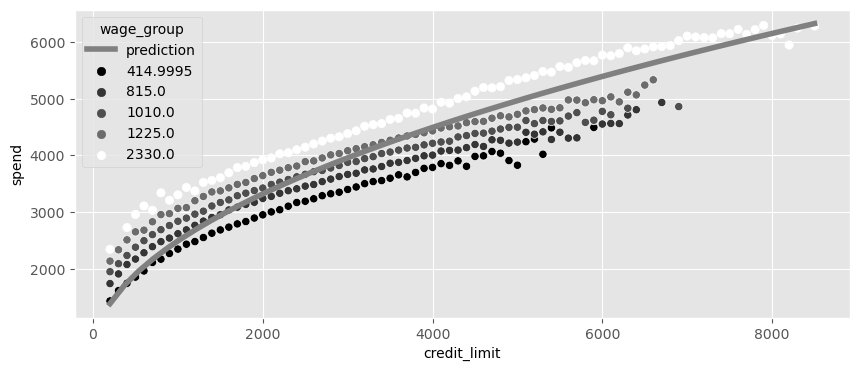

In [27]:
plt_df = (spend_data
          .assign(wage_group = lambda d: pd.IntervalIndex(pd.qcut(d["wage"], 5)).mid)
          .groupby(["wage_group", "credit_limit"])
          [["spend"]]
          .mean()
          .reset_index()
         )

x = np.linspace(plt_df["credit_limit"].min(), plt_df["credit_limit"].max())

plt.figure(figsize=(10,4))
plt.plot(x, model_spend.params[0] + model_spend.params[1]*np.sqrt(x), color="C1", label="prediction", lw=4)
plt.legend()
sns.scatterplot(data=plt_df, 
                x="credit_limit",
                y="spend",
                palette="gray",
                hue="wage_group")

모델에 임금을 포함하면 아래와 같음

$$ spend_i = \beta_0 + \beta_1 \sqrt{line_i} + \beta_2 wage_i + e_i $$

다시 $\beta_1$을 추정하면 임금 수준이 소비에 미치는 영향의 편향되지 않은 추정값을 얻을 수 있음(임금이 유일한 교란 요인이라고 가정했을 경우에만)

해당 추정값은 앞서 얻은 값보다 작으며 이는 모델에 임금을 포함함으로써 상향 편향을 보정했기 때문

In [28]:
model_spend = smf.ols('spend ~ np.sqrt(credit_limit)+wage',
                     data = spend_data).fit()

model_spend.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,383.5002,2.746,139.662,0.000,378.118,388.882
np.sqrt(credit_limit),43.8504,0.065,672.633,0.000,43.723,43.978
wage,1.0459,0.002,481.875,0.000,1.042,1.050


### 4.6.2 비선형 FWL과 편향 제거

비선형 데이터에 FWL 정리를 적용하기 위해서는 먼저 비선형 처리를 해야하며 선형회귀분석을 이ㅛㅇ해 비선형 모델을 추정하는 과정은 아래와 같음

1. **처치 선형화 단계:** $T$와 $Y$의 관계를 선형화하는 함수 $F$를 찾는다.
2. **편향 제거 단계:** $F(T)$를 교란 요인 $X$에 회귀하고 처치 잔차 $\widetilde{F(T)} = F(T) - \widehat{F(T)}$를 구한다.
3. **잡음 제거 모델:** 결과 $Y$를 교란 요인 $X$에 회귀하고 결과 잔차 $\tilde{Y} = Y - \hat{Y}$를 구한다.
4. **결과 모델 단계:** 이렇게 얻은 결과 모델은 결과 잔차 $\tilde{Y}$를 처치 잔차 $\widetilde{F(T)}$에 회귀하여 $F(T)$가 $Y$에 미치는 인과효과의 추정값을 구한다.

신용 한도와 소비 사례에서 $F$는 제곱근 함수이기에 비선형성을 고려하여 FWL 정리를 적용하는 방법은 아래와 같음(시각화를 위해 처치 잔차와 결과 잔차에 각각 $\overline{F(lines)}$와 $\overline{spend}$를 추가함)

In [29]:
debias_spend_model = smf.ols(f'np.sqrt(credit_limit) ~ wage',
                            data=spend_data).fit()

denoise_spend_model = smf.ols(f'spend~wage',
                            data=spend_data).fit()

credit_limit_sqrt_deb = (debias_spend_model.resid
                         + np.sqrt(spend_data['credit_limit']).mean())
spend_den = denoise_spend_model.resid + spend_data['spend'].mean()


spend_data_deb = (spend_data.assign(credit_limit_sqrt_deb = credit_limit_sqrt_deb,
                                   spend_den = spend_den))

final_model = smf.ols(f'spend_den ~ credit_limit_sqrt_deb',
                   data=spend_data_deb).fit()

final_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1493.6990,3.435,434.818,0.000,1486.966,1500.432
credit_limit_sqrt_deb,43.8504,0.065,672.640,0.000,43.723,43.978


여기서 얻은 $\beta_1$ 추정값은 앞서 교란 요인인 임금과 처치를 모두 포함한 완전모델을 실행하여 얻은 추정값과 완전히 동일하며 이 모델의 예측값을 원본 데이터와 비교해 그려봣을 때 이전처럼 상향 편향되지 않음을 확인할 수 있음

대신 임금 그룹의 중간을 정확히 통과함

<Axes: xlabel='credit_limit', ylabel='spend'>

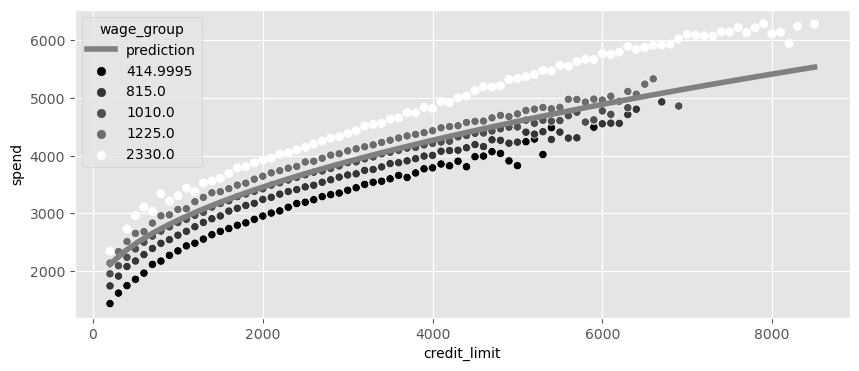

In [30]:
plt_df = (spend_data
          .assign(wage_group = lambda d: pd.IntervalIndex(pd.qcut(d["wage"], 5)).mid)
          .groupby(["wage_group", "credit_limit"])
          [["spend"]]
          .mean()
          .reset_index())

x = np.linspace(plt_df["credit_limit"].min(), plt_df["credit_limit"].max())

plt.figure(figsize=(10,4))
plt.plot(x, (final_model.params[0] 
             + final_model.params[1]*np.sqrt(x)),
         color="C1", label="prediction", lw=4)

plt.legend()

sns.scatterplot(data=plt_df, 
                x="credit_limit",
                y="spend",
                palette="gray",
                hue="wage_group")

## 4.7 더미변수를 활용한 회귀분석

회귀분석과 직교화는 좋으나 결국 독립성 가정을 해야 하며 이를 위해서는 일부 공변량을 통제했을 때 처치가 무작위로 배정된 것처럼 보이도록 해야 하나 이는 매우 어려운 일임  
모델에 모든 교란 요인이 포함되는지 판단하기는 매우 어려우므로 가능하면 무작위 실험을 진행하는 것이 좋음

예를 들어 은행에서 신용 한도를 무작위로 배정할 경우 채무불이행률과 고객 소비에 미치는 영향을 추정하는 일은 훨씬 간단해지지만 이러한 무작위 통제 실험에는 큰 비용이 들 수 있음  
채무 불이행 가능성이 높아 큰 손실을 초래할 수 있는 고객들에게 신용 한도를 무작위로 설정하는 상황이 발생할 수 있기 때문

### 4.7.1 조건부 무작위 실험

이 난관을 해결하기 위해서는 계층화(stratified) 또는 조건부(conditionally) 무자구이 실험을 선택하는 것  
모든 고객에게 동일한 확률 분포에서 완전히 무작위로 신용 한도를 설정하는 실험을 설계하는 대신 고객 공변량에 따라 서로 다른 분포에서 표본을 뽑아 여러 국소 실험을 만드는 것임

예를 들어 credit_score1 변수가 고객 위험도의 대리변수임을 알고 있으므로 해당 변수를 사용하여 위험도에 따른 고객 그룹을 생성할 수 있음(credit_score1이 비슷한 고객들을 묶는 것)  
이후 credit_score1이 낮은 고 위험 그룹은 평균이 낮은 분포에서 신용 한도를 추출하여 무작위로 배정하고 credit_score1이 높은 저위험 고객은 평균이 높은 분포에서 추출하여 신용 한도를 무작위로 배정함

In [31]:
risk_data_rnd = pd.read_csv('C:\\Users\\bumbk\\causal-inference-in-python-code\\data\\risk_data_rnd.csv')
risk_data_rnd.head()

,wage,educ,exper,married,credit_score1,credit_score2,credit_score1_buckets,credit_limit,default
0,890.0,11,16,1,490.0,500.0,400,5400.0,0
1,670.0,11,7,1,196.0,481.0,200,3800.0,0
2,1220.0,14,9,1,392.0,611.0,400,5800.0,0
3,1210.0,15,8,1,627.0,519.0,600,6500.0,0
4,900.0,16,1,1,275.0,519.0,200,2100.0,0


신용 한도의 히스토그램을 credit_score1_buckets 별로 표시하면 신용 한도가 서로 다른 분포에서 추출되었음을 알 수 있음  
점수가 높은 고객(저위험 고객) 그룹은 히스토그램이 오른쪽으로 치우치며(왼쪽으로 꼬리가 김) 더 높은 신용한도를 나타냄

반대로 더 위험한 고객(점수가 낮은 고객) 그룹은 왼쪽으로 치우치며(오른쪽으로 꼬리가 김) 신용한도가 더 낮음

이러한 실험은 최적의 신용 한도에서 크게 벗어나지 않으면서 실험 비용을 관리할 수 있는 수준으로 낮춤

Text(0.5, 1.0, 'Conditional random experiment')

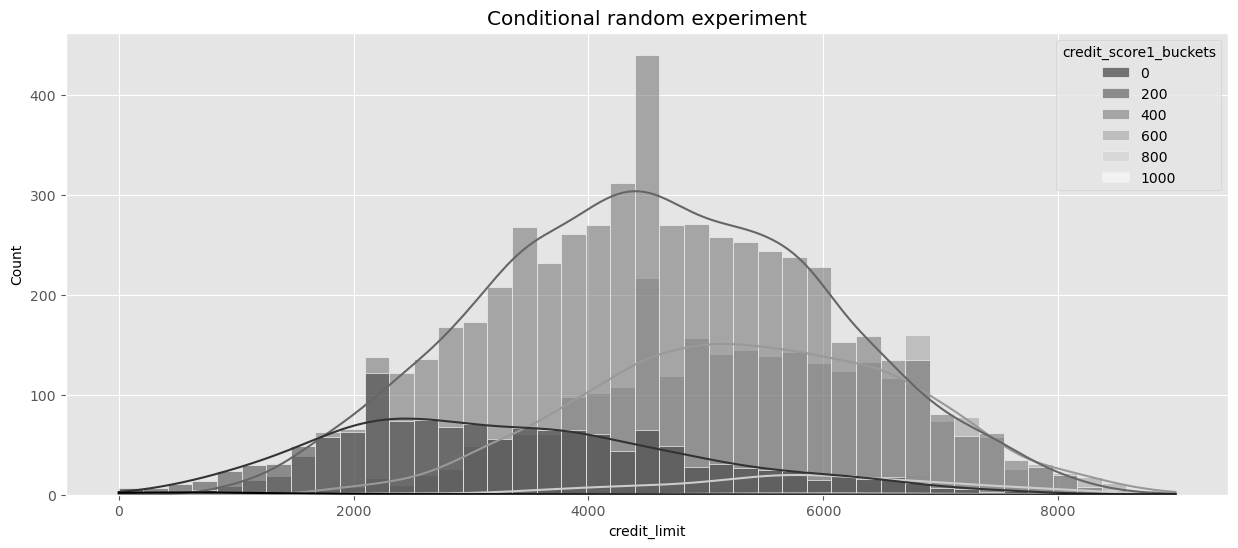

In [32]:
plt.figure(figsize=(15,6))
sns.histplot(data=risk_data_rnd,
             x="credit_limit",
             hue="credit_score1_buckets",
             kde=True,
             palette="gray");
plt.title("Conditional random experiment")

그렇다고 조건부 무작위 실험이 무작위 실험보다 항상 좋은 것은 아님

조건부 무작위 실험은 비용이 더 저렴하지만 훨씬 복잡하기에 어떤 이유로든 조건부 무작위 실험을 선택한다면 가능한 한 완전 무작위 실험에 가깝게 설계해야 함

- 그룹 수가 적을수록 조건부 무작위 실험을 진행하기가 더 쉬워진다. 이 예에서는 0~1,000 사이의 범위에 있는 credit_score1을 200 단위로 나눠 그룹이 5개만 존재한다.  
처치 분포가 서로 다른 여러 그룹을 결합하면 복잡해지므로 적은 수의 그룹을 유지하는 것이 좋다.

- 그룹 간 처치 분포가 많이 중첩될수록 분석이 용이해진다. 이는 양수성 가정과 관련이 있는데, 이 사례에서 고위험 그룹이 높은 신용 한도를 받을 확률이 0인 경우 고위험 그룹이 높은 신용 한도를 받게 된다면 어떤 일이 발생할지 알기 위해 위험한 외삽에 의존해야 한다.

위 두 가지 경험적 규칙을 최대한 적용하면 완전한 무작위 실험으로 돌아가게 되는데, 이는 두 가지 규칙 모두에 trade-off가 있음을 의미함
그룹 수가 적고 겹치는 부분이 많을수록 실험 결과 해석이 쉬워지지만 더 큰 비용이 소요되며 그 반대도 마찬가지임

* 계층화 실험(stratified experiment)은 분산을 최소화하고 계층화된 변수에 대해 실험군과 대조군 사이의 균형을 보장하기 위한 방법임  
그러나 이 적용 사례에서는 모든 그룹 또는 계층에서 처치 분포가 동일하도록 설계됨

### 4.7.2 더미변수

조건부 무작위 실험의 장접은 설정한 범주형 변수에 따라 신용 한도가 무작위로 배정되었음을 알기에 조건부 독립 가정에 훨씬 더 설득력이 생긴다는 점임  
그러나 실험군에 대한 결과만으로 단순 회귀분석을 하면 편향된 추정값을 얻게 된다는 단점이 있음

예를 들어 교란 요인을 포함하지 않고 모델을 추정하면 결과는 아래와 같음

$$ default_i = \beta_0 + \beta_1 lines_i + e_i $$

In [33]:
model = smf.ols('default ~ credit_limit', data=risk_data_rnd).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1369,0.009,15.081,0.000,0.119,0.155
credit_limit,-9.344e-06,1.85e-06,-5.048,0.000,-1.3e-05,-5.72e-06


위 결과를 해석해봤을 때 인과 매개변수 추정값인 $\hat{\beta_1}$은 음수임  
더 높은 신용 한도가 고객의 채무불이행 위험을 낮추지는 않으므로 추정값이 음수인 것은 말이 되지 않음

이 결과가 나온 이유는 실험이 설계된 방식으로 인해 위험도가 낮은 고객(credit_score1이 높은 고객)이 평균적으로 더 높은 한도를 받았기 때문

이를 보정하기 위해서는 모델에 처치가 무작위로 배정된 그룹 정보를 포함해야 함  
여기서는 credit_score1_buckets를 통제해야 하며 이 변수는 숫자로 표현되지만 실제로는 범주형 변수임

따라서 그룹 자체를 통제하는 방법은 dummy variable을 만드는 것이며 이는 그룹에 대해 이진값으로 구성된 열을 의미함  
고객이 해당 그룹에 속하면 1이고 그렇지 않으면 0이며 고객은 하나의 그룹에만 속할 수 있으므로 더미 열 중 오직 하나만 1의 값을 가지고 나머지는 모두 0임(머신러닝에서의 one-hot encoding과 같음)

pandas에서는 pd.get_dummies 함수를 사용해 dummy variable을 만들 수 있으며 아래 코드를 통해 그룹을 나타내는 열인 credit_score1_buckets를 전달하고 접두사 sb(score bucket)가 붙은 더미 열을 만드는 과정을 보여줌  
또한 첫 번째 더미를 제외함(더미 열 중 하나는 불필요하기 때문 + 다중공선성 문제)

In [34]:
risk_data_dummies = (
    risk_data_rnd.join(pd.get_dummies(risk_data_rnd['credit_score1_buckets'],
                                     prefix='sb', drop_first=True))
)

In [35]:
risk_data_dummies.head()

,wage,educ,exper,married,credit_score1,credit_score2,credit_score1_buckets,credit_limit,default,sb_200,sb_400,sb_600,sb_800,sb_1000
0,890.0,11,16,1,490.0,500.0,400,5400.0,0,0,1,0,0,0
1,670.0,11,7,1,196.0,481.0,200,3800.0,0,1,0,0,0,0
2,1220.0,14,9,1,392.0,611.0,400,5800.0,0,0,1,0,0,0
3,1210.0,15,8,1,627.0,519.0,600,6500.0,0,0,0,1,0,0
4,900.0,16,1,1,275.0,519.0,200,2100.0,0,1,0,0,0,0


dummy variable을 모델에 추가하고 $\beta_1$을 다시 추정한 결과는 아래와 같음

$$ default_i = \beta_0 + \beta_1 lines_i + \theta \mathbf{G}_i + e_i $$

이를 통해 보다 타당한 추정값을 얻을 수 있으며 해당 추정값은 양수이고 신용 한도가 높을수록 채무불이행 위험이 높아짐을 나타냄

In [36]:
model = smf.ols('default ~ credit_limit + sb_200+sb_400+sb_600+sb_800+sb_1000',
               data=risk_data_dummies).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2253,0.056,4.000,0.000,0.115,0.336
credit_limit,4.652e-06,2.02e-06,2.305,0.021,6.97e-07,8.61e-06
sb_200,-0.0559,0.057,-0.981,0.327,-0.168,0.056
sb_400,-0.1442,0.057,-2.538,0.011,-0.256,-0.033
sb_600,-0.2148,0.057,-3.756,0.000,-0.327,-0.103
sb_800,-0.2489,0.060,-4.181,0.000,-0.366,-0.132
sb_1000,-0.2541,0.094,-2.715,0.007,-0.438,-0.071


In [37]:
###statsmodels를 사용할 대는 식에 C() 함수를 넣어 dummy vairable을 만드는 것도 가능함

model = smf.ols('default ~ credit_limit + C(credit_score1_buckets)',
               data=risk_data_rnd).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2253,0.056,4.000,0.000,0.115,0.336
C(credit_score1_buckets)[T.200],-0.0559,0.057,-0.981,0.327,-0.168,0.056
C(credit_score1_buckets)[T.400],-0.1442,0.057,-2.538,0.011,-0.256,-0.033
C(credit_score1_buckets)[T.600],-0.2148,0.057,-3.756,0.000,-0.327,-0.103
C(credit_score1_buckets)[T.800],-0.2489,0.060,-4.181,0.000,-0.366,-0.132
C(credit_score1_buckets)[T.1000],-0.2541,0.094,-2.715,0.007,-0.438,-0.071
credit_limit,4.652e-06,2.02e-06,2.305,0.021,6.97e-07,8.61e-06


교란 요인을 통제하려고 dummy variable을 추가하긴 했으나 그룹당 하나의 절편이 생기는 것과 달리 모든 그룹에 동일한 기울기가 적용됨  
해당 기울기는 각 그룹의 회귀에 대한 분산 가중평균이 되며 각 그룹에 대한 모델의 예측 결과를 시각화하면 그룹별로 하나의 선이 있고 모든 선의 기울기가 동일함을 알 수 있음

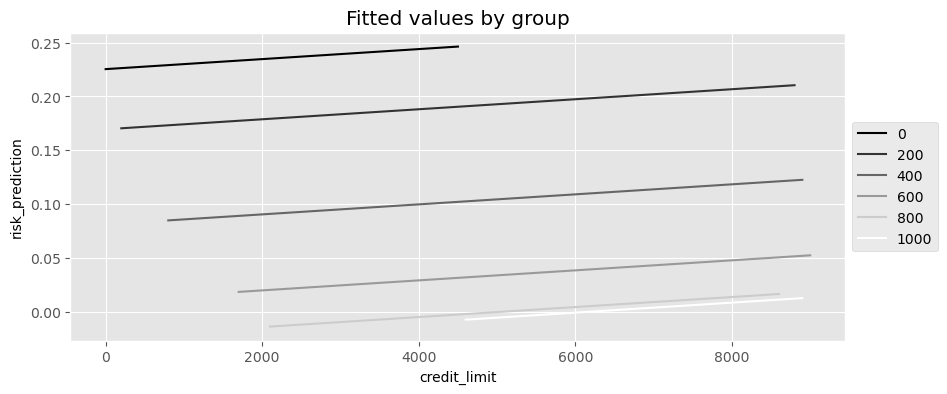

In [38]:
plt_df = (risk_data_rnd
          .assign(risk_prediction = model.fittedvalues)
          .groupby(["credit_limit", "credit_score1_buckets"])
          ["risk_prediction"]
          .mean()
          .reset_index())

plt.figure(figsize=(10,4))
sns.lineplot(data=plt_df,
             x="credit_limit", y="risk_prediction", hue="credit_score1_buckets", palette = 'gray');
plt.title("Fitted values by group")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### 4.7.3 포화회귀모델

이진 처치에 대한 회귀분석은 실험군과 대조군의 평균을 비교하는 것과 같으며 dummy variable은 이진값이므로 같은 논리가 여기에도 적용됨  
만약 회귀분석에 익숙하지 않다면 첫 시도로 조건부 무작위 실험의 데이터를 credit_score1_buckets에 따라 나누고 그룹별로 효과를 추정할 것임

In [39]:
def regress(df, t, y):
    return smf.ols(f'{y} ~ {t}', data=df).fit().params[t]

effect_by_group = (risk_data_rnd.groupby('credit_score1_buckets').apply(regress, y='default', t='credit_limit'))

effect_by_group

credit_score1_buckets
0      -0.000071
200     0.000007
400     0.000005
600     0.000003
800     0.000002
1000    0.000000
dtype: float64

이 방법을 통해 그룹별 효과를 알 수 있으나 평균을 어떻게 구할지에 대해서는 결정이 필요함  
아래는 각 그룹의 크기를 가중치로 삼아 가중평균을 취한 것

In [40]:
group_size = risk_data_rnd.groupby('credit_score1_buckets').size()

ate = (effect_by_group * group_size).sum() / group_size.sum()
ate

4.4904456287487205e-06

회귀분석에서도 같은 작업을 수행할 수 있으며 이를 포화모델(saturated model)이라고 함

dummy variable과 처치에 대한 상호작용(interaction)항에서 각 dummy variable에 해당하는 그룹의 인과효과를 추정할 수 있으며 여기서는 첫 번째 dummy variable을 제외했으므로 credit_limit과 관련된 매개변수는 생략된 dummy group sb_100의 효과를 나타냄.

이 값은 앞서 0에서 200 사이의 credit_score1_buckets 그룹에 대해 추정된 값인 -0.000071과 동일함

In [41]:
model = smf.ols('default ~ credit_limit * C(credit_score1_buckets)',
               data=risk_data_rnd).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.3137,0.077,4.086,0.000,0.163,0.464
C(credit_score1_buckets)[T.200],-0.1521,0.079,-1.926,0.054,-0.307,0.003
C(credit_score1_buckets)[T.400],-0.2339,0.078,-3.005,0.003,-0.386,-0.081
C(credit_score1_buckets)[T.600],-0.2957,0.080,-3.690,0.000,-0.453,-0.139
C(credit_score1_buckets)[T.800],-0.3227,0.111,-2.919,0.004,-0.539,-0.106
C(credit_score1_buckets)[T.1000],-0.3137,0.428,-0.733,0.464,-1.153,0.525
credit_limit,-7.072e-05,4.45e-05,-1.588,0.112,-0.000,1.66e-05
credit_limit:C(credit_score1_buckets)[T.200],7.769e-05,4.48e-05,1.734,0.083,-1.01e-05,0.000
credit_limit:C(credit_score1_buckets)[T.400],7.565e-05,4.46e-05,1.696,0.090,-1.18e-05,0.000
credit_limit:C(credit_score1_buckets)[T.600],7.398e-05,4.47e-05,1.655,0.098,-1.37e-05,0.000


상호작용 매개변수는 생략된 첫 번째 그룹의 효과와 연관 지어 해석해야 하기에 credit_limit과 관련된 매개변수와 상호작용 항을 더하면 회귀분석을 사용해 그룹별로 추정된 효과를 얻을 수 있음(이는 그룹별로 하나의 효과를 각각 추정할 때와 결과가 동일함)

In [42]:
(model.params[model.params.index.str.contains('credit_limit:')]
 + model.params['credit_limit']).round(9)

credit_limit:C(credit_score1_buckets)[T.200]     0.000007
credit_limit:C(credit_score1_buckets)[T.400]     0.000005
credit_limit:C(credit_score1_buckets)[T.600]     0.000003
credit_limit:C(credit_score1_buckets)[T.800]     0.000002
credit_limit:C(credit_score1_buckets)[T.1000]    0.000000
dtype: float64

이 모델의 그룹별 예측값을 시각화하면 그룹마다 별도의 회귀 모델을 적합시킨 것처럼 보이며 각 선은 절편 뿐만 아니라 기울기도 다름

또한 포화모델에는 매개변수(자유도)가 더 많으며 이는 다른 모든 조건이 동일할 때 분산이 더 큼을 의미함

다음 그래프를 보면 이 맥락과 맞지 않는 기울기가 음인 선이 나타나지만 이 기울기는 통계적으로 유의하지 않으며 해당 그룹에서의 작은 표본 크기 때문에 발생한 잡음일 가능성이 높음

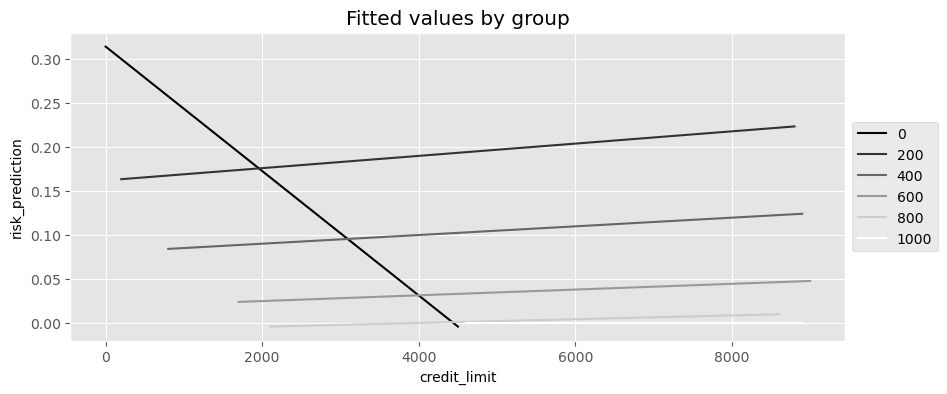

In [43]:
plt_df = (risk_data_rnd
          .assign(risk_prediction = model.fittedvalues)
          .groupby(["credit_limit", "credit_score1_buckets"])
          ["risk_prediction"]
          .mean()
          .reset_index())

plt.figure(figsize=(10,4))
sns.lineplot(data=plt_df,
             x="credit_limit", y="risk_prediction", hue="credit_score1_buckets",  palette="gray");
plt.title("Fitted values by group")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### 4.7.4 분산의 가중평균과 회귀분석

상호작용항 없이 default ~ credit_limit + C(credit_score1_buckets) 모델을 실행하면 단일 효과, 즉 하나의 기울기 매개변수만 얻게 됨  
이 효과 추정값은 그룹별 효과를 추정하고 그룹 크기를 가중치로 사용해 평균한 결과와 다르다는 점이 중요함  
결국 회귀분석은 여러 그룹의 효과를 합친 것이지만 표본 크기를 기준으로 한 가중평균은 아님

아래 시뮬레이션 데이터를 통해 가중평균이 아닌 무엇인지 알아볼 수 있음  
총 두 개의 다른 그룹에서 데이터를 시뮬레이션하며 첫 번재 그룹은 크기는 1,000이고 평균 처치효과는 1, 두 번째 그룹의 크기는 500이고 평균 처치효과는 2임(표준편차는 각각 1과 2)

In [44]:
np.random.seed(123)

#std(t) = 1
t1 = np.random.normal(0, 1, size=1000)
df1 = pd.DataFrame(dict(t=t1, 
                        y=1*t1, # ATE=1 
                        g=1,))

#std(t) = 2
t2 = np.random.normal(0, 2, size=500)
df2 = pd.DataFrame(dict(t=t2,
                        y=2*t2, # ATE=2
                        g=2,))

df = pd.concat([df1, df2])
df.head()

,t,y,g
0,-1.085631,-1.085631,1
1,0.997345,0.997345,1
2,0.282978,0.282978,1
3,-1.506295,-1.506295,1
4,-0.578600,-0.578600,1


In [47]:
###그룹 별 효과 추정 및 그룹 크기를 가중치로 사용한 평균 결과인 ATE

effect_by_group = df.groupby('g').apply(regress, y='y', t='t')

ate = (effect_by_group * df.groupby('g').size()).sum() / df.groupby('g').size().sum()
ate

1.333333333333333

그룹을 통제하면서 y를 t에 회귀하면 매우 다른 결과를 보이며 그룹 2의 표본이 그룹 1의 절반임에도 결합한 효과는 그룹 2의 효과에 더 가까움

In [49]:
model = smf.ols('y ~ t + C(g)', data=df).fit()
model.params

Intercept    0.024758
C(g)[T.2]    0.019860
t            1.625775
dtype: float64

이는 회귀분석이 그룹 효과를 결합할 때 표본 크기를 가중치로 사용하지 않기 때문이며 대신 각 그루베엇 처치의 분산에 비례하는 가중치를 사용함  
회귀분석은 처치 변동성이 큰 그룹을 선호하며 처치가 많이 변할수록 결과에 미치는 영향이 더 분명해짐

결국 여러 그룹이 있고 각 그룹 내에서 처치가 무작위 배정된 경우, 조건부 원칙(보정 공식)에 따르면 효과는 각 그룹 내 효과의 가중평균임

$$ ATE = E\{ \lgroup \frac{\partial}{\partial t} E \left[ Y_i | T = t,Group_i \right] \rgroup w(Group_i)\} $$

사용하는 방법에 따라 다른 가중치를 적용할 수 있음  
회귀분석에서는 $w(Group_i) \propto \sigma^2(T)$를 사용하지만 $w(Group_i) = N_{Group}$와 같이 표본 크기를 가중치로 사용하여 그룹 효과에 직접 가중치를 부여할 수 있음

### 4.7.5 평균 제거와 고정효과

그룹이 많을 때 각 그룹에 dummy를 추가하려면 번거롭고 연산 과정이 복잡하며 대부분이 0인 많은 열을 생성하게 됨  
그러나 이 문제는 dummy variable에 대해 FWL 정리를 적용하고 회귀분석이 처치를 직교화하는 방법을 이해하면 쉽게 해결할 수 있음

FWL 정리에서 편향 제거 단계는 공변량에서 처치를 예측하는 과정을 포함하며 여기서는 공변량이 dummy variable임

In [50]:
model_deb = smf.ols('credit_limit ~ C(credit_score1_buckets)',
                   data=risk_data_rnd).fit()

model_deb.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1173.0769,278.994,4.205,0.000,626.193,1719.961
C(credit_score1_buckets)[T.200],2195.4337,281.554,7.798,0.000,1643.530,2747.337
C(credit_score1_buckets)[T.400],3402.3796,279.642,12.167,0.000,2854.224,3950.535
C(credit_score1_buckets)[T.600],4191.3235,280.345,14.951,0.000,3641.790,4740.857
C(credit_score1_buckets)[T.800],4639.5105,291.400,15.921,0.000,4068.309,5210.712
C(credit_score1_buckets)[T.1000],5006.9231,461.255,10.855,0.000,4102.771,5911.076


dummy variable은 기본으로 그룹 평균과 비슷한 역할을 수행하므로 dummy variable이 포함된 모델을 활용하면 그룹 평균에 대한 값을 예측할 수 있음  
credit_score1_buckets=0 이면 credit_score1_buckets=0 그룹의 평균 신용 한도를 예측하고 credit_score1_buckets=1 이면 credit_score_buckets=1 그룹의 평균 신용한도(해당 그룹의 계수 1173.0769와 절편 2195.4337을 더한 3368.510638)를 예측하며 이 값들은 정확히 각 그룹의 평균값임

In [52]:
risk_data_rnd.groupby('credit_score1_buckets')['credit_limit'].mean()

credit_score1_buckets
0       1173.076923
200     3368.510638
400     4575.456498
600     5364.400448
800     5812.587413
1000    6180.000000
Name: credit_limit, dtype: float64

dummy variable을 활용하면 처치를 잔차화하고 싶을 때 훨씬 더 간단하고 효과적인 방법으로 할 수 있음을 의미함

In [53]:
risk_data_fe = risk_data_rnd.assign(credit_limit_avg = lambda d:(d.groupby('credit_score1_buckets')['credit_limit'].transform('mean')))

이후 처치에서 해당 그룹의 평균을 빼고 잔차를 구함

이 방식은 처치의 평균을 제거하므로 종종 처치에 대해 평균 제거(de-meaning)한다고 하며 회귀식 내에서 이를 수행하려면 수학 연산자 I(...)로 감싸주면 됨

In [54]:
model = smf.ols('default ~ I(credit_limit - credit_limit_avg)',
                data=risk_data_fe).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0935,0.003,32.121,0.000,0.088,0.099
I(credit_limit - credit_limit_avg),4.652e-06,2.05e-06,2.273,0.023,6.4e-07,8.66e-06


여기서 얻은 매개변수 추정값은 모델에 더미변수를 추가해 얻은 값과 동일하며 이 둘은 수학적으로 동등(equivalent)하기 때문임

이렇듯 그룹 내에서 고정된 모든 것들을 통제하여 얻은 모델을 고정효과 모델(fixed effect model)이라고 하며 고정된 것을 통제하는 수단(ex. dummy variable)을 고정효과라고 함

회귀분석은 추가된 변수들로부터 처치를 잔차화하므로 회귀 모델 안에 그룹별 평균 처치를 포함시키는 방식 역시 거의 동일한 효과를 보임

In [55]:
model = smf.ols('default ~ credit_limit + credit_limit_avg',
                data=risk_data_fe).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4325,0.020,21.418,0.000,0.393,0.472
credit_limit,4.652e-06,2.02e-06,2.305,0.021,6.96e-07,8.61e-06
credit_limit_avg,-7.763e-05,4.75e-06,-16.334,0.000,-8.69e-05,-6.83e-05


## 4.8 누락 변수 편향

공통 원인(교란 원인)이 처치와 결과 간의 추정 관계를 편향시킬 수 있기에 회귀 모델에는 이러한 요인들을 포함해서 다뤄야함  
또한 회귀분석은 교란 편향에 대해 고유한 관점을 제공하며 더 정확하게 다룰 수 있도록 함

신용 한도가 채무불이행률에 미치는 영향을 추정할 때 임금이 유일한 교란 요인이라고 가정

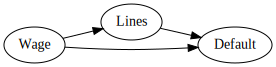

In [57]:
g = gr.Digraph(graph_attr={"rankdir":"LR"})


g.edge("Lines", "Default")
g.edge("Wage", "Default"),
g.edge("Wage", "Lines")


g

이 경우 교란 요인을 포함하는 모델을 추정해야 함

$$ default_i = \beta_0 + \beta_1 lines_i + \beta_2 wage_i + e_i $$

다음과 같이 교란 요인이 누락된 축소모델을 추정할 경우 추정값은 편향됨

$$ default_i = \beta_0 + \beta_1 lines_i + e_i $$

In [58]:
short_model = smf.ols('default ~ credit_limit', data=risk_data).fit()
short_model.params['credit_limit']

-2.4019619925968776e-05

이렇듯 신용 한도가 높아지면 채무불이행률이 낮아지는 것처럼 보이나 아직 모르는 부분은 해당 편향의 크기를 정확하게 파악할 수 있기에 조금 더 봐야 함

회귀분석을 통해 누락 변수 편향(omitted variable bias, OVB)은 아래와 같이 정의할 수 있음

1. 누락 변수가 포함된 전체 모델의 회귀계수 더하기
2. 결과에 미치는 누락 변수의 효과 곱하기
3. 누락 변수를 포함된 변수에 회귀하는 모델의 회귀계수


하나씩 살펴보자면 먼저 $T$에 대한 $Y$의 단순회귀분석은 실제 인과 매개변수 $\tau$에 편향을 더한 결과임

$$ \frac{Cov(T,Y)}{Var(T)} = \tau + \beta^\prime_{omitted}\ \delta_{omitted} $$

위 편향식은 결과에 대한 누락 교란 요인의 회귀계수 $\delta_{omitted}$를 곱한 값이며 다음 코드를 통해 누락 변수 편향의 공식을 구현하고 앞서 얻은 편향된 매개변수 추정값을 확인할 수 있음

In [59]:
long_model = smf.ols('default ~ credit_limit + wage',
                     data=risk_data).fit()

omitted_model = smf.ols('wage ~ credit_limit', data=risk_data).fit()

(long_model.params['credit_limit'] + long_model.params['wage'] * omitted_model.params['credit_limit'])

-2.4019619925968796e-05

## 4.9 중립 통제변수

교란 요인 $X$를 보정하면서 처치 $T$가 $Y$에 미치는 영향을 알고 싶다면 모델에 $X$를 포함하면 됨  
다른 방법으로는 $X$를 사용해 $T$를 예측한 후 잔차를 구하고 이 잔차를 편향 제거된(debiased) 처치로 사용해도 같은 결과를 얻을 수 있음  
결국 $X$를 고정한 상태에서 $Y$를 잔차에 회귀하면 $T$와 $Y$의 관계를 알 수 있는 것임

그렇다고 모든 변수를 회귀 모델에 포함시키는 것은 바람직하지 않으며 공통 효과(충돌부)나 매개자는 선택편향을 유발할 수 있으므로 포함시키지 않는 것이 좋음  
하지만 일부 변수가 무해해 보이지만 실제로는 해로울 수 있는 통제변수들은 고려해야 함  
이러한 통제 변수는 회귀분석 추정에서 편향에 영향을 미치지 않는다는 점에서는 중립적(neural)이라고 하지만 분산에는 심각한 영향을 줄 수 있음  
회귀 모델에 특정 변수를 포함할 때는 편향-분산 트레이드오프(Bias-Variance Tradeoff)가 존재한다는 점을 명심해야 함

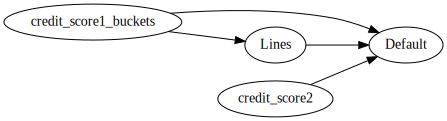

In [60]:
g = gr.Digraph(graph_attr={"rankdir":"LR"})

g.edge("credit_score1_buckets", "Default"),
g.edge("credit_score1_buckets", "Lines"),
g.edge("credit_score2", "Default"),
g.edge("Lines", "Default")

g

위 DAG를 살펴봤을 때 모델에 credit_score2를 포함하지 않는다면 credit_score1_buckets를 보정하기 때문에 이 겨로가는 편향되지 않으며 지금까지와 동일한 결과를 얻을 수 있음

아래는 credit_score2를 포함했을 때 결과임

In [61]:
formula = 'default ~ credit_limit+C(credit_score1_buckets)+credit_score2'

model = smf.ols(formula, data=risk_data_rnd).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.5576,0.055,10.132,0.000,0.450,0.665
C(credit_score1_buckets)[T.200],-0.0387,0.055,-0.710,0.478,-0.146,0.068
C(credit_score1_buckets)[T.400],-0.1032,0.054,-1.898,0.058,-0.210,0.003
C(credit_score1_buckets)[T.600],-0.1410,0.055,-2.574,0.010,-0.248,-0.034
C(credit_score1_buckets)[T.800],-0.1161,0.057,-2.031,0.042,-0.228,-0.004
C(credit_score1_buckets)[T.1000],-0.0430,0.090,-0.479,0.632,-0.219,0.133
credit_limit,4.928e-06,1.93e-06,2.551,0.011,1.14e-06,8.71e-06
credit_score2,-0.0007,2.34e-05,-30.225,0.000,-0.001,-0.001


위 결과를 살펴봤을 때 먼저 credit_limit의 매개변수 추정값이 조금 더 커진 것을 확인할 수 있음  
그러나 이것보다 중요한 것은 표준오차가 감소했다는 것이며 이는 credit_score2가 결과 $Y$를 잘 예측하고 선형회귀의 잡음 제거 단계에 기여했기 때문임  
FWL의 마지막 단계가 credit_score2를 포함하므로 $\tilde Y$의 분산이 감소하고 이를 $\tilde T$에 회귀하면 더 정확한 결과를 얻을 수 있음

이는 선형회귀의 매우 흥미로운 특징이며 선형회귀분석은 교란 요인을 보정하는 데 사용할 수 있을 뿐만 아니라 잡음을 줄이는 데도 사용할 수 있음

결국 결과를 예측할 수 있고 선택편향을 유발하지 않는 변수를 포함하면 됨

* 마이크로소프트에서 개발해 여러 IT 회사에서 사용하는 **CUPED**가 또다른 잡음 제거 방법이며 기본 개념은 FWL 정리의 잡음 제거 과정과 매우 유사함

### 4.9.1 잡음 유발 통제변수

통제변수는 잡음을 줄일 수도 있지만 반대로 잡음을 늘릴 수도 있음

이번에는 신용 한도가 위험도가 아닌 소비에 미치는 영향을 추정하고 이전 예제에서와 같이 credit_score1이 주어졌을 때 신용 한도는 무작위로 배정되었다고 가정함  
그러나 이번에는 credit_score1이 교란 요인이 아니라고 가정하고 credit_score1은 처치의 원인이지만 결과의 원인은 아님

이때 인과 그래프는 아래와 같음

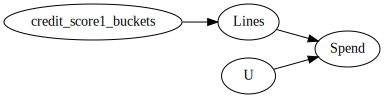

In [62]:
g = gr.Digraph(graph_attr={"rankdir":"LR"})


g.edge("credit_score1_buckets", "Lines"),
g.edge("U", "Spend"),
g.edge("Lines", "Spend")

g

이는 신용 한도가 지출에 미치는 인과효과를 얻으려고 credit_score1을 보정할 필요가 없음을 의미함  
인과효과 추정을 위해 단순회귀만으로 충분하며 처치 반응의 오목성을 반영하기 위해 제곱근 함수를 적용함

In [63]:
spend_data_rnd = pd.read_csv('C:\\Users\\bumbk\\causal-inference-in-python-code\\data\\spend_data_rnd.csv')

model = smf.ols('spend ~ np.sqrt(credit_limit)',
                data=spend_data_rnd).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2153.2154,218.600,9.850,0.000,1723.723,2582.708
np.sqrt(credit_limit),16.2915,2.988,5.452,0.000,10.420,22.163


이때 credit_score1_buckets를 포함하면 아래와 같은 결과가 나옴

In [64]:
model = smf.ols('spend ~ np.sqrt(credit_limit)+C(credit_score1_buckets)',
                data=spend_data_rnd).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2367.4867,556.273,4.256,0.000,1274.528,3460.446
C(credit_score1_buckets)[T.200],-144.7921,591.613,-0.245,0.807,-1307.185,1017.601
C(credit_score1_buckets)[T.400],-118.3923,565.364,-0.209,0.834,-1229.211,992.427
C(credit_score1_buckets)[T.600],-111.5738,570.471,-0.196,0.845,-1232.429,1009.281
C(credit_score1_buckets)[T.800],-89.7366,574.645,-0.156,0.876,-1218.791,1039.318
C(credit_score1_buckets)[T.1000],363.8990,608.014,0.599,0.550,-830.720,1558.518
np.sqrt(credit_limit),14.5953,3.523,4.142,0.000,7.673,21.518


표준 오차가 증가하여 인과 매개변수의 신뢰구간이 넓어진 것을 확인할 수 있으며 이는 OLS가 처치의 분산이 큰 그룹을 선호하기 때문  
이때 처치를 설명하는 공변량을 통제하면 효과적으로 분산을 줄일 수 있음

### 4.9.2 특성 선택: 편향-분산 트레이드오프

현실적으로 볼 때 대체로 공변량이 처치에 영향을 주지만 결과에는 영향을 주지 않는 경우를 찾아보기 어려움  
대부분의 경우 $T$와 $Y$ 모두에 영향을 미치는 교란 요인이 있을 것이며 이들은 서로 다른 정도로 영향을 미침

공변량은 보정해야 하는 교란 요인이므로 모든 편향을 제거하려면 모든 공변량을 포함해야 함  
그러나 처치의 원인인 공변량을 보정하면 추정량의 분산이 증가함

In [65]:
np.random.seed(123)

n = 100
(x1, x2, x3) = (np.random.normal(0, 1, n) for _ in range(3))
t = np.random.normal(10 * x1 + 5 * x2 + x3)

### ATE = 0.05
y = np.random.normal(0.05 * t + x1 + 5 * x2 + 10 * x3, 5)
df = pd.DataFrame(dict(y=y, t=t, x1=x1, x2=x2, x3=x3))

smf.ols('y ~ t+x1+x2+x3', data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2707,0.527,0.514,0.608,-0.775,1.316
t,0.8664,0.607,1.427,0.157,-0.339,2.072
x1,-7.0628,6.038,-1.170,0.245,-19.049,4.923
x2,0.0143,3.128,0.005,0.996,-6.195,6.224
x3,9.6292,0.887,10.861,0.000,7.869,11.389


위 예제에서 실제 ATE는 0.5이고 모든 교란 요인을 통제하면서 이 효과를 추정하면 추정값의 표준오차가 너무 크기에 제대로 된 결론을 도출할 수 없음

교란 요인 중 하나가 처치의 강력한 예측자(predictor)이고 결과의 약한 예측자임을 알면 모델에서 제외할 수 있음  
위 예제에서는 $X_1$이 해당하며 이러헥 하면 추정값이 편향될 수 있음에 주의해야 함  
그러나 분산을 크게 줄인다면 감안할 가치가 있을 수도 있음

In [66]:
smf.ols('y ~ t+x2+x3', data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1889,0.523,0.361,0.719,-0.849,1.227
t,0.1585,0.046,3.410,0.001,0.066,0.251
x2,3.6095,0.582,6.197,0.000,2.453,4.766
x3,10.4549,0.537,19.453,0.000,9.388,11.522


기본저긍로 모델에 더 많은 교란 요인을 포함(보정)할수록 인과 추정값의 편향을 줄어들게 됨  
그러나 결과 예측력은 약하지만 처치 예측력은 강한 변수를 포함하면 편향이 감소하는 대신 분산이 증가한다는 큰 문제가 발생함  
결국 분산을 줄이기 위해 약간의 편향 증가를 감수해야 될 수도 있으며 모든 교란 요인이 동일한 영향을 주는 것이 아님을 인지해야 함

물론 모든 교란 요인은 $T$와 $Y$에 영향을 끼친다는 공통점이 있으나 처치를 잘 설명하고 결과를 거의 설명하지 않는 다면 보정 대상에서 배제해야 함  
이는 회귀분석에만 해당되는 것이 아니라 성향점수 가중치와 같은 다른 편향 보정 방법에도 동일하게 적용 됨

인과추론에서 처치를 설명하는 데 교란 요인의 영향이 어느 정도 약해야 해당 변수를 제거할 수 있는지에 대한 기준은 아직 명확하지 않음  
그러나 이러한 bias-variance tradeoff가 존재한다는 사실을 알면 선형회귀의 매커니즘을 이해하고 설명하는 데 도움이 될 것임

## 4.10 요약

인과추론에서의 회귀분석은 주로 교란 요인을 보정하거나 분산 감소에 사용됨  
조건부 독립성이 유지될 때 직교화를 이용하여 처치가 무작위로 배정된 것처럼 보이게 할 수 있다는 것이 중요함  
수학적으로는 $Y_t \perp T | X$일 때 $T$를 $X$에 회귀하고 잔차를 구하여 $X$로 인한 교란편향을 보정할 수 있으며 이러한 잔차는 편향 제거된 처치로 볼 수 있음

이 접근법은 FWL 정리를 활용해 발전되었으며 이 정리에 따르면 다중회귀분석은 다음과 같이 세 단계로 나누어 설명할 수 있음

1. 편향 제거 단계: 처치 $T$를 교란 요인 $X$에 대해 회귀하여 처치 잔차 $\tilde{T} = T - \hat{T}$를 구함
2. 잡음 제거 단계: 결과 $Y$를 교란 요인 $X$에 대해 회귀하여 결과 잔차 $\tilde{Y} = Y - \hat{Y}$를 구함
3. 결과 모델 단계: 결과 잔차 $\tilde Y$를 처치 잔차 $\tilde T$에 대해 회귀하여 $T$가 $Y$에 미치는 인과효과의 추정값을 구하는 결과 모델임